## Introduction

This project was made in loving memory of my grandmother, Donna Leung. 

In this notebook, I utilize Google Colab to create two Convolutional Neural Network (CNN) models. The first model is a binary classification model to identify brain tumors by virtue of a yes or no model. The second model is a multiple classification model with 4 classes; glioma, meningioma, no tumor, and pituitary. Due to the nature of multiclass models there is a higher likelihood of misclassifying an image. In an effort to reduce misclassification I my first model as a high accuracy binary classificaion model to determine whether or not there is a tumor to flag. Then the multiclass model is fed the same image to attempt to classify the tumor. 

# Table of Contents

* [Functions Used](#Functions_Used)
* [Data Sorting and Cleaning](#Data_Sorting_and_Cleaning)
* [Binary Classification Model](#Binary_Classification_Model)
* [Baseline Model](#Baseline_Model)
* [Image Cleaning and Manipulation](#Image_Cleaning_and_Manipulation)
* [Hyperparameter Tuning (Binary)](#Hyperparameter_Tuning_(Binary))
* [Multiclassification Model](#Multiclassification_Model)
* [Hyperparameter Optimization (Multiclass)](#Hyperparameter_Optimization_* (Multiclass))
* [Summary](#Summary)
* [Next Steps](#Next_Steps)


## Resources
*   References
  *   [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)
  *   [PyImage Search Gurus](https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) 
*   Data Sources
  *   [Binary data](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
  *   [Clean multiclass data](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)
  *   [Not so clean multiclass data](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import random
import shutil

import imutils
import cv2
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,\
 Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, EfficientNetB0

## Functions Used

In [ ]:
def model_eval(X_train, y_train, X_test, y_test, X_val, y_val):
  '''fn accepts above input variables and 
  returns the associated score from the most recent model'''
  train_results = model.evaluate(X_train, y_train) 
  test_results = model.evaluate(X_test, y_test)
  val_results = model.evaluate(X_val, y_val)

  return (f"Train:{train_results}, Test:{test_results}, Val:{val_results}")

In [ ]:
def save_new_images(X, y, file_path):

  '''fn reforms image files from the np.array back into a jpg'''
  i = 0
  for (img, imclass) in zip(X, y):
      if imclass == 'neg':
          cv2.imwrite(file_path + '/neg/' + str(i) + '.jpg', img)
      else:
          cv2.imwrite(file_path + '/pos/' + str(i) + '.jpg', img)
      i += 1


In [ ]:
def crop_images(images, add_pixels_value=0):
  '''fn identifies all "extreme" points of an image and crops a 
  rectangular cut based on the extreme points. Code adapted from pyimagesearch'''
  cropped = []
  # load the images, convert to greyscale and blur slightly
  for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    # thresholds image then perform a series of erosions and 
    # dilations to remove small regions of noise
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
      cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # extract extreme points
    # extLeft (West) is the X-axis min
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    # extRight (East) X-axis max
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    # extTop Y-axis max (North)
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    # extBot Y-axis min (South)
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # cropping step
    ADD_PIXELS = add_pixels_value
    new_img = image[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,\
                  extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    cropped.append(new_img)

  return np.array(cropped)

## Data Sorting and Cleaning

In [ ]:
path = '/content/drive/MyDrive/Colab/capstone/data/archive'
os.chdir(path)

In [ ]:
## The following code block is commented out to prevent file duplication
# # code block shuffles and evenly splits 'yes' and 'no' file images into 
# # train, test, val folders 'pos' and 'neg' folders
# # Each folder contains a 1:1 split of 'yes' and 'no' images
# # The original data set has more 'no' images than 'yes'. 

# yes_images = os.listdir('yes')
# no_images = os.listdir('no')

# # randomize the images
# random.shuffle(yes_images)
# random.shuffle(no_images) 

# #70% train, 20% test, 10% val
# pos_train_images = int(len(yes_images)*0.7)
# pos_test_images = int(len(yes_images)*0.2)
# pos_val_images = int(len(yes_images)*0.1)

# neg_train_images = int(len(no_images)*0.7)
# neg_test_images = int(len(no_images)*0.2)
# neg_val_images = int(len(no_images)*0.1)

# # select the images
# train_yes = yes_images[:pos_train_images]
# train_no = no_images[:neg_train_images]

# # move the files into each respective folder
# for image in train_yes:
#   shutil.move(f'yes/{image}', 'train/pos')
# for image in train_no:
#   shutil.move(f'no/{image}', 'train/neg')

# # redeclare variable with with the prior images removed
# yes_images = yes_images[pos_train_images:]
# no_images = no_images[neg_train_images:]

# # rinse and repeat for test and val

# test_yes = yes_images[:pos_test_images]
# test_no = no_images[:neg_test_images]

# for image in test_yes:
#   shutil.move(f'yes/{image}', 'test/pos')
# for image in test_no:
#   shutil.move(f'no/{image}', 'test/neg')

# yes_images = yes_images[pos_test_images:]
# no_images = no_images[neg_test_images:]

# val_yes = yes_images[:pos_val_images]
# val_no = no_images[:neg_val_images]

# for image in val_yes:
#   shutil.move(f'yes/{image}', 'val/pos')
# for image in val_no:
#   shutil.move(f'no/{image}', 'val/neg')

In [ ]:
# # This code block will move all the images back into their original folders
# # Always have an exit plan!

# train_pos_images = os.listdir('train/pos')
# train_neg_images = os.listdir('train/neg')

# for image in train_pos_images:
#   shutil.move(f'train/pos/{image}', 'yes')

# for image in train_neg_images:
#   shutil.move(f'train/neg/{image}', 'no')

# test_pos_images = os.listdir('test/pos')
# test_neg_images = os.listdir('test/neg')

# for image in test_pos_images:
#   shutil.move(f'test/pos/{image}', 'yes')

# for image in test_neg_images:
#   shutil.move(f'test/neg/{image}', 'no')

# val_pos_images = os.listdir('val/pos')
# val_neg_images = os.listdir('val/neg')

# for image in val_pos_images:
#   shutil.move(f'val/pos/{image}', 'yes')

# for image in val_neg_images:
#   shutil.move(f'val/neg/{image}', 'no')

In [ ]:
# For ease of use, I've decided to use Image Data Generator
datagen = ImageDataGenerator()

# Binary Classification Model

My baseline 46.5% yes images. As a dry run I will construct a basic model to see if I need to alter the images in any way.

In [ ]:
train_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive/train/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['neg', 'pos'],
    class_mode='binary',
    batch_size= 32,
    shuffle=True,
    seed=33
)

test_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive/test/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['neg', 'pos'],
    class_mode='binary',
    batch_size= 32,
    shuffle=True,
    seed=33
)

val_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive/val/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['neg', 'pos'],
    class_mode='binary',
    batch_size= 32,
    shuffle=True,
    seed=33
)

Found 2100 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [ ]:
# Although I do not need to define/separate my generators for X and y, I do so
# to be able to explore the data a little deeper.
X_train, y_train = train_data.next()
X_test, y_test = test_data.next()
X_val, y_val = val_data.next()

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((32, 224, 224, 3), (32,), (32, 224, 224, 3), (32,), (32, 224, 224, 3), (32,))

## Baseline Model

The baseline model is more of a proof of concept to see if my intuition is correct. I will expand upon this model at a later step.

*   kernel size (3, 3) to get as many meaningful snapshots as possible
*   input shape (224, 224, 3) - 224 x 224 for the image size because after 5 max pools, images go from (224, 224) -> (7, 7) and has a distinct center point opposed to (256, 256) -> (8, 8). This can help account for objects in an image at the center of the image. 



In [ ]:
model = Sequential()

model.add(
    Conv2D(32, kernel_size=(3, 3), 
           activation='relu', input_shape=(224, 224, 3)))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(
    Conv2D(64, kernel_size=(3, 3),
           activation='relu')
)

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics =['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
# I set the epochs 1000 as I'm sure the model won't reach that point 
# since it's a binary model but didn't want to arbitrarily cut off
# the process.
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    validation_data = (X_test, y_test),
                    epochs = 1000,
                    callbacks = [early_stopping],
                    verbose =0)

In [ ]:
model_eval(X_train, y_train, X_test, y_test, X_val, y_val)

1/1 [==============================] - 0s 39ms/step - loss: 16.6155 - accuracy: 0.6875


'Train:[7.635308130107127e-14, 1.0], Test:[11.820557594299316, 0.6875], Val:[16.61553955078125, 0.6875]'

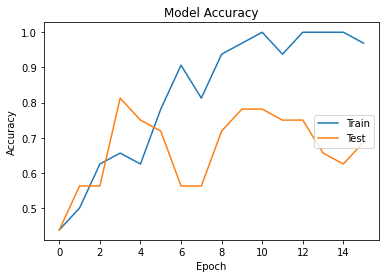

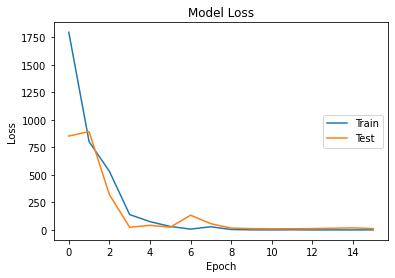

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'right')
plt.show()

For a basic model, we see it only went to 15 epochs and is overfit. Scores are:
Train/Test/Val = 100%, 65.6%, 65.6%.

Before attempting transfer learning, I want to use the architecture described in the VGG16 CNN model. 

[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

I decided to use VGG16 for this process mostly due to it's renown in this image classification modeling. From what I understand, the architecture has 13 convolutional layers, 5 max pooling layers, and 3 dense layers with 16 of the layers carrying weights (hence the 16). 

In [ ]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten(name='flatten'))

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics =['accuracy'])

es = EarlyStopping(monitor = 'val_loss', patience = 10)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    validation_data = (X_test, y_test),
                    epochs = 1000,
                    callbacks = [es],
                    verbose = 0)

In [ ]:
model_eval(X_train, y_train, X_test, y_test, X_val, y_val)

1/1 [==============================] - 0s 192ms/step - loss: 0.7876 - accuracy: 0.3125


'Train:[0.6456354856491089, 0.625], Test:[0.6556792259216309, 0.5625], Val:[0.7876430749893188, 0.3125]'

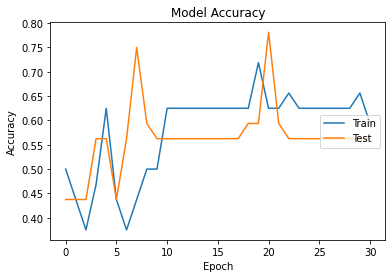

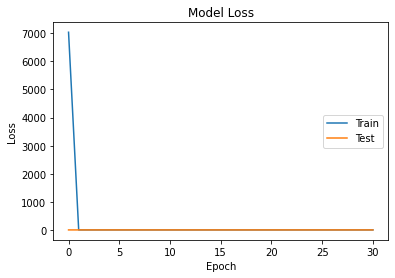

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'right')
plt.show()

Overall, the model is signifcantly less overfit but doesn't handle new data very well. From here I will implement transfer learning and utilize VGG16 to it's fullest and to give the model a better chance I will standardize all the images. It is at this point I realize not all of the images are of the same size or contain the image within the same space; there are some images with more black space than others. 

## Image Cleaning and Manipulation

[PyImage Search Gurus](https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) 

The following code is adapted from PyImage Search Gurus.

In [ ]:
# testing the code with a random image
image = cv2.imread('/content/drive/MyDrive/Colab/capstone/data/archive/train/pos/y396.jpg')
image = cv2.resize(image, dsize = (224, 224), interpolation=cv2.INTER_CUBIC)
# INTER_CUBIC: This uses bicubic interpolation for resizing the image. 
# While resizing and interpolating new pixels, this method acts on the 4×4 
# neighboring pixels of the image. It then takes the weights average of the 
# 16 pixels to create the new interpolated pixel.
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5,5), 0)


thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
  cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# extract extreme points
# extLeft (West) is the X-axis min
extLeft = tuple(c[c[:, :, 0].argmin()][0])
# extRight (East) X-axis max
extRight = tuple(c[c[:, :, 0].argmax()][0])
# extTop Y-axis max (North)
extTop = tuple(c[c[:, :, 1].argmin()][0])
# extBot Y-axis min (South)
extBot = tuple(c[c[:, :, 1].argmax()][0])

# cropping step
ADD_PIXELS = 0
new_img = image[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,\
              extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

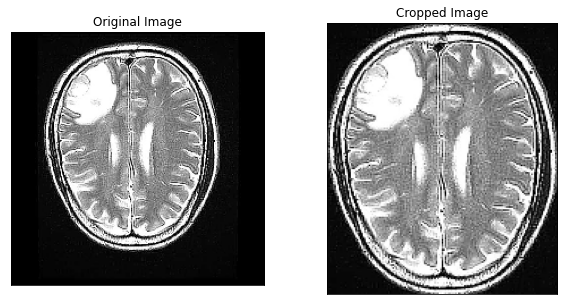

In [ ]:
fig, ax = plt.subplots(1, 2, figsize= (10,5))

ax[0].imshow(image)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Original Image')

ax[1].imshow(new_img)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Cropped Image')

plt.show()

In [ ]:
# for this function to work, I need to reimport my data as np.arrays.

labels = ['neg', 'pos']
image_size = 224
# empty lists to append the np.arrays to
X_train = []
y_train = []
X_test = []
y_test = []
X_val = []
y_val = []
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab/capstone/data/archive/','train',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab/capstone/data/archive/','test',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab/capstone/data/archive/','val',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_val.append(img)
        y_val.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

cropped_X_train = crop_images(images = X_train)
cropped_X_test = crop_images(images = X_test)
cropped_X_val = crop_images(images = X_val)

<ipython-input-24-bfbf791a9fa0>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(cropped)


In [ ]:
# # commenting out to prevent file duplication

# save_new_images(cropped_X_train, y_train, file_path + '/train')
# save_new_images(cropped_X_test, y_test, file_path + '/test')
# save_new_images(cropped_X_val, y_val, file_path+ '/val')

Now to import the cropped image files as a data generator.

In [ ]:
datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive/cropped/train/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['neg', 'pos'],
    class_mode='binary',
    batch_size= 32,
    shuffle=True,
    seed=33
)

test_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive/cropped/test/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['neg', 'pos'],
    class_mode='binary',
    batch_size= 32,
    shuffle=True,
    seed=33
)

val_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive/cropped/val/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['neg', 'pos'],
    class_mode='binary',
    batch_size= 32,
    shuffle=True,
    seed=33
)

Found 2100 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


## Transfer Learning with VGG16

In [ ]:
# Import VGG16
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# freezing the base layers as to not overwrite
for layer in vgg.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(vgg)
# Adding a final layer like one we'd find in the model.
# The original model uses maxpooling 2D, trying average instead.
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics =['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 5)

Due to the added processing time from the complexity of the VGG16 model, I've decided to hard cap the process at 50 epochs with a patience of 5.

In [ ]:
history = model.fit(train_data,
                    batch_size = 8,
                    validation_data = test_data,
                    epochs = 50,
                    callbacks = [es],
                    verbose = 0)

## Hyperparameter Tuning (Binary)

While about 97% test and 95% val accuracy is quite good, I have a little extra time and want to cover all my bases. I'll take a look at how some other optimizers perform and see if there's better performance or what the tradeoffs are.

#### Available optimizers
* SGD
* RMSprop
* Adam
* AdamW - Adam but with a w! Uses adaptive estimations
* Adadelta
* Adagrad
* Adamax
* Adafactor - more commonly usd in NLP
* Nadam - is RMSprop but with momentum
* Ftrl - Better used for shallow modles and sparse feature space

In [ ]:
# creating a dictionary to store model parameters.
accuracy_dict= {'optimizer': [], 'test_accuracy': [], 'val_accuracy': []}

In [ ]:
# model.evaluate(train_data), model.evaluate(test_data), model.evaluate(val_data)
accuracy_dict['optimizer'].append('Adam')
accuracy_dict['test_accuracy'].append(history.history['val_accuracy'][-1])
accuracy_dict['val_accuracy'].append(model.evaluate(val_data)[-1])

10/10 [==============================] - 62s 7s/step - loss: 0.0896 - accuracy: 0.9667


In [ ]:
accuracy_dict

{'optimizer': ['Adam'],
 'test_accuracy': [0.9750000238418579],
 'val_accuracy': [0.9666666388511658]}

In [ ]:
# Optimizing model parameters:

# list of optimizers to use from the available list taken from the Keras webiste
# Of the ones listed, I feel SGD, RMSprop and Adadelta may lead to similar 
# or maybe better performance than our defacto Adam.
optimizers = ['SGD', 'RMSprop', 'Adadelta']

# creating a dict to store the scores
# accuracy_dict= {'optimizer': [], 'accuracy': []}

# create a for loop to iterate through the list and test each optimizer

for optimizer in optimizers:
  model = Sequential()
  model.add(vgg)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))

  es = EarlyStopping(monitor = 'val_loss', patience = 5)
  # in order to set the learning rate of each optimizer, I'll have to instantiate each one 
  optimizer_ins = getattr(tf.optimizers, optimizer)(learning_rate=0.0001)

  model.compile(optimizer=optimizer_ins, loss='binary_crossentropy', metrics =['accuracy'])
  history = model.fit(train_data,
                    batch_size = 8,
                    validation_data = test_data,
                    epochs = 50,
                    callbacks = [es],
                    verbose = 0)
  accuracy_dict['optimizer'].append(optimizer)
  accuracy_dict['test_accuracy'].append(history.history['val_accuracy'][-1])
  accuracy_dict['val_accuracy'].append(model.evaluate(val_data)[-1])

10/10 [==============================] - 2s 154ms/step - loss: 0.6831 - accuracy: 0.6067


In [ ]:
accuracy_df = pd.DataFrame(accuracy_dict)

In [ ]:
accuracy_df

,optimizer,test_accuracy,val_accuracy
0,Adam,0.975000,0.966667
1,SGD,0.656667,0.676667
2,RMSprop,0.968333,0.976667
3,Adadelta,0.633333,0.606667


The test accuracy is doing a bit better on Adam than RMSprop but RMSprop has a higher validation accuracy. It's a tough call but I will use Adam. Adam (short for Adaptive Moment Estimation) takes advantage of momentum and RMSProp, which tends to work better in most cases. In this case, Adam is working very similarly to RMSprop but considering my sample size is not the largest, with additional data, having the Adam optimizer should achieve better results in the future. 

In [ ]:
adam_drop_dict = {'dropout': [], 'test_accuracy': [], 'val_accuracy': []}

In [ ]:
# testing various dropout parameters
dropouts = [0.7, 0.5, 0.3, 0.1]
for dropout in dropouts:  
  model = Sequential()
  model.add(vgg)

  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
                loss='binary_crossentropy', 
                metrics =['accuracy'])
  es = EarlyStopping(monitor = 'val_loss', patience = 5)
  history = model.fit(train_data,
                    batch_size = 8,
                    validation_data = test_data,
                    epochs = 50,
                    callbacks = [es],
                    verbose = 0)
  adam_drop_dict['dropout'].append(dropout)
  adam_drop_dict['test_accuracy'].append(history.history['val_accuracy'][-1])
  adam_drop_dict['val_accuracy'].append(model.evaluate(val_data)[-1])

10/10 [==============================] - 2s 152ms/step - loss: 0.0647 - accuracy: 0.9733


In [ ]:
best_drop = pd.DataFrame(adam_drop_dict)
best_drop

,dropout,test_accuracy,val_accuracy
0,0.7,0.970000,0.983333
1,0.5,0.978333,0.956667
2,0.3,0.968333,0.970000
3,0.1,0.968333,0.973333


Note: dropout 0.7 is inconsistent. In my deeper dive 'vgg_bianaryclass' notebook, under the same conditions, 0.7 dropout yielded  93% accuracy. Due to the inconsistency in the output, I've chosen 0.5 as my dropout as it was the most consistent.

Recompiling the model for export

In [ ]:
model = Sequential()
model.add(vgg)

model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics =['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 5)
history = model.fit(train_data,
                  batch_size = 8,
                  validation_data = test_data,
                  epochs = 50,
                  callbacks = [es],
                  verbose = 0)

In [ ]:
history = history.history

In [ ]:
binary_path = '/content/drive/MyDrive/Colab/capstone/models/vgg_binary_h5/'
# # commenting out to prevent overwriting the original export
# with open(binary_path+'binary_history.pkl', 'wb') as f:
#   pickle.dump(history, f)

In [ ]:
with open(binary_path+'binary_history.pkl', 'rb') as f:
  history = pickle.load(f)

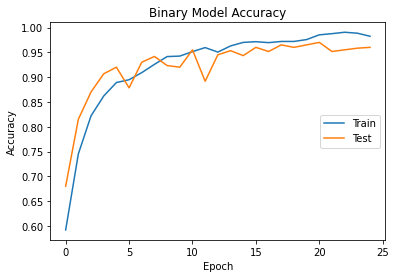

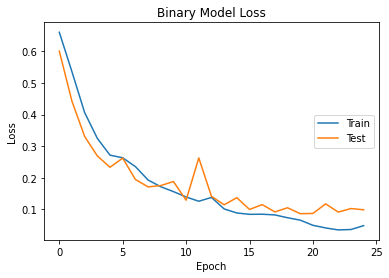

In [ ]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Binary Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Binary Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'right')
plt.show()

In [ ]:
# # commenting out to prevent overwriting original
# model.save('/content/drive/MyDrive/Colab/capstone/models/vgg_binary_h5/binary_model.h5')

# Multiclassification Model

I perform similar work to the binary classification model, only I forgo recreating repetitive steps in this notebook. For greater detail, please refer to 'vgg_multiclass' notebook in the notebooks folder.

Multiclass data is split up as so:
23.11% Glioma, 23.45% Meningioma, 28.51% No Tumor, and 25.05% pituitary

In [ ]:
path = '/content/drive/MyDrive/Colab/capstone/data/archive-2'
os.chdir(path)

# code commented out after execution to prevent remaking directories
# test_folder = '/content/drive/MyDrive/Colab/capstone/data/archive-2/cropped_testing'

# os.makedirs(os.path.join(test_folder, 'glioma'))
# os.makedirs(os.path.join(test_folder, 'meningioma'))
# os.makedirs(os.path.join(test_folder, 'notumor'))
# os.makedirs(os.path.join(test_folder, 'pituitary'))

# train_folder = '/content/drive/MyDrive/Colab/capstone/data/archive-2/cropped_training'

# os.makedirs(os.path.join(train_folder, 'glioma'))
# os.makedirs(os.path.join(train_folder, 'meningioma'))
# os.makedirs(os.path.join(train_folder, 'notumor'))
# os.makedirs(os.path.join(train_folder, 'pituitary'))


# # archive-3 contains images that are not ideal/cleaned MRI images. I use this
# # set of data to limit test the model with messy MRI scans.
# train_folder = '/content/drive/MyDrive/Colab/capstone/data/archive-3/cropped_training'

# os.makedirs(os.path.join(train_folder, 'glioma_tumor'))
# os.makedirs(os.path.join(train_folder, 'meningioma_tumor'))
# os.makedirs(os.path.join(train_folder, 'no_tumor'))
# os.makedirs(os.path.join(train_folder, 'pituitary_tumor'))

# test_folder = '/content/drive/MyDrive/Colab/capstone/data/archive-3/cropped_testing'

# os.makedirs(os.path.join(test_folder, 'glioma_tumor'))
# os.makedirs(os.path.join(test_folder, 'meningioma_tumor'))
# os.makedirs(os.path.join(test_folder, 'no_tumor'))
# os.makedirs(os.path.join(test_folder, 'pituitary_tumor'))

In [ ]:
# # I've altered the code from the binary classification step to be easier to
# # parse here. Commented out to prevent duplication.

# subfolders = ['glioma', 'meningioma', 'notumor', 'pituitary']
# folderPath = '/content/drive/MyDrive/Colab/capstone/data/archive-2/'
# image_size = 224

# # iterate through each folder:
# for directory in ['Testing', 'Training']:
#   # set current directory, this should set the directory to Testing or Training
#   current_path = os.path.join(folderPath, directory)
#   # iterate through the list of subfolders:
#   for subfolder in subfolders:
#     # set current path to the subfolder (ie Testing/glioma)
#     subfolder_path = os.path.join(current_path, subfolder)
#     # for all image files in the subfolder:
#     for image_file in os.listdir(subfolder_path):
#       # targets each image file specifically
#       image_path = os.path.join(subfolder_path, image_file)
#       # declare the image file as an object/load it in
#       image = cv2.imread(image_path)
#       # crop the image with my custom function
#       cropped_image = crop_images([image])[0]
#       # set destination file to export the cropped image
#       # the destination is "cropped_testing" or "cropped_training so I need to set directory.lower()
#       destination = os.path.join(folderPath, 'cropped_' + directory.lower() ,subfolder)
#       # set the save path for the actual file
#       save_path = os.path.join(destination, image_file)
#       cv2.imwrite(save_path, cropped_image)

In [ ]:
# # transforming the validation data
# subfolders = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
# folderPath = '/content/drive/MyDrive/Colab/capstone/data/archive-3/'
# image_size = 224

# # iterate through each folder:
# for directory in ['Testing', 'Training']:
#   # set current directory, this should set the directory to Testing or Training
#   current_path = os.path.join(folderPath, directory)
#   # iterate through the list of subfolders:
#   for subfolder in subfolders:
#     # set current path to the subfolder (ie Testing/glioma)
#     subfolder_path = os.path.join(current_path, subfolder)
#     # for all image files in the subfolder:
#     for image_file in os.listdir(subfolder_path):
#       # targets each image file specifically
#       image_path = os.path.join(subfolder_path, image_file)
#       # declare the image file as an object/load it in
#       image = cv2.imread(image_path)
#       # crop the image with my custom function
#       cropped_image = crop_images([image])[0]
#       # set destination file to export the cropped image
#       # the destination is "cropped_testing" or "cropped_training so I need to set directory.lower()
#       destination = os.path.join(folderPath, 'cropped_' + directory.lower() ,subfolder)
#       # set the save path for the actual file
#       save_path = os.path.join(destination, image_file)
#       cv2.imwrite(save_path, cropped_image)

In [ ]:
datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive-2/cropped_training/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['glioma', 'meningioma', 'notumor', 'pituitary'],
    class_mode='categorical',
    batch_size= 32,
    shuffle=True,
    seed=33
)

test_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive-2/cropped_testing/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['glioma', 'meningioma', 'notumor', 'pituitary'],
    class_mode='categorical',
    batch_size= 32,
    shuffle=True,
    seed=33
)

val_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive-3/cropped_testing/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['glioma', 'meningioma', 'notumor', 'pituitary'],
    class_mode='categorical',
    batch_size= 32,
    shuffle=True,
    seed=33
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


A baseline model was created using the same architecture as the binary model adjusted for categorical crossentropy. The results were abyssmal at roughly 30% and I've omitted the code from this notebook. Please refer to 'vgg_multiclass.ipynb' in my notebooks folder for reference. 

In [ ]:
# Import VGG16
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# freezing the base layers as to not overwrite
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
model = Sequential()
model.add(vgg)
# Adding a final layer like one we'd find in the model.
# The original model uses maxpooling 2D, trying average instead.
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
history = model.fit(train_data,
                    batch_size = 16,
                    validation_data = test_data,
                    epochs = 50,
                    callbacks = [es],
                    verbose = 0)

## Hyperparameter Optimization (Multiclass)

A list of optimizers was attempted but the overall run time exceeded the time allowed by Google Colab. The explored list of opimizers are as follows:

*   'Adam', 'Adadelta', 'Adagrad', 'Adamax'

In [ ]:
accuracy_dict= {'dropout_prob': [], 'test_accuracy': []}

Number of epochs adjusted to 30 since the previous run showed about 25 epochs to hit bottom out. 

In [ ]:
dropouts = [0.7, 0.5, 0.3]

for drop in dropouts:
  model = Sequential()
  model.add(vgg)

  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(drop)) # dropout parameter here
  model.add(Dense(4, activation='softmax'))

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy', 
                metrics =['accuracy'])
  es = EarlyStopping(monitor = 'val_loss', patience = 5)

  history = model.fit(train_data,
                    batch_size = 8,
                    validation_data = test_data,
                    epochs = 30,
                    callbacks = [es],
                    verbose = 0)
  accuracy_dict['dropout_prob'].append(drop)
  accuracy_dict['test_accuracy'].append(history.history['val_accuracy'][-1])

In [ ]:
dropout_df = pd.DataFrame(accuracy_dict)
dropout_df

,dropout_prob,test_accuracy
0,0.7,0.922197
1,0.5,0.922960
2,0.3,0.933638


In [ ]:
# Recompiling final model for export
model = Sequential()
model.add(vgg)

model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 5)

history = model.fit(train_data,
                  batch_size = 8,
                  validation_data = test_data,
                  epochs = 30,
                  callbacks = [es],
                  verbose = 0)

In [4]:
# history = history.history
mu_path = '/content/drive/MyDrive/Colab/capstone/models/vgg_multi_h5/'
# # commenting out any writes to directory to prevent file duplication/overwriting
# with open(mu_path+'multi_history.pkl', 'wb') as f:
#   pickle.dump(history, f)

with open(mu_path+'multi_history.pkl', 'rb') as f:
  history = pickle.load(f)


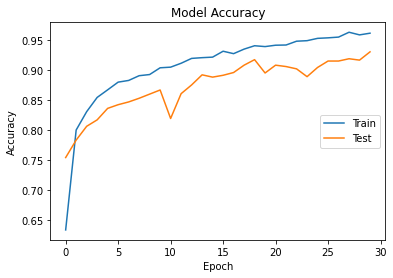

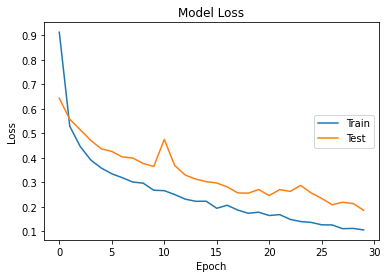

In [5]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'right')
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/Colab/capstone/models/vgg_multi_h5/model.h5')
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab/capstone/models/vgg_multi_h5/multi_model.h5')

In [ ]:
loaded_model.summary() # sanity check

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_11  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_44 (Dense)            (None, 1024)              525312    
                                                                 
 dense_45 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_46 (Dense)            (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                     

In [ ]:
loaded_model.evaluate(test_data, verbose=0)

[0.2574535012245178, 0.9138062596321106]

Final model accuracy is 91.4% on test.

For this final test, I am using not ideal validation data wherein the images are blurry, offset, or any number of non-ideal situations. This will help limit test the model in it's current state and will determine how I move forward.

In [ ]:
loaded_model.evaluate(val_data,verbose=0)

[1.810529351234436, 0.6852791905403137]

Utilizing messy MRI scans yields a 68.5% accuracy overall. This is pretty good for not being trained in any capacity on messy images but not practical for real world use. 

## Summary

My binary model had to beat a baseline of 46.5% (tumor positive) and did so with an accuracy of 97.8% test and 95.7% validation using the Adam optimizer with a Dropout layer of 0.5. 

My multiclass model had to beat roughly 30% with a test accuracy of 91.4% and a hard validation set of 68.5%. Note the validation set for this specific example uses images that were not cleaned up and are considered messy images. 

I've created a Streamlit application, the code for which is in the Streamlit folder dubbed 'application.py'. The code for the application is provided below with comments.

## Next Steps

Due to time constraints, I will have to leave the models as they currently stand. There are a few areas I want to revisit and improve upon the models further.



1.   Binary model
  *   Generate more data by virtue of image manipulation
      *   Flip images along the horizontal and veritcal axis'
      *   Slightly rotate each image by 5, 10, 20 etc. degrees
      *   Slightly blur images by varying degrees to account
  *   Gather more images to train the models on
2.   Multiclass model
  *   Do very much the same for as the Binary model
  *   gather additional images and expand the categories; why stop at 3 types?
3.   Learn to better leverage resources from Google Colab to speed up modeling
4.   Revisit RMSprop when more data is available. The early model for the binary classifier showed promising results with RMSprop. To truly test my hypothesis of Adam being better overall, I will need to test it by revisiting this with the expanded data set. 

In [ ]:
import streamlit as st
import keras
import os
from PIL import Image
import numpy as np
import cv2
import imutils
import shutil
import tempfile
from image_processing import crop_images 

user_image = st.file_uploader("Upload an image...", type=["jpg", "jpeg", "png"])

#create a temporary direcory to store the st file for transformations
# file path
temp_dir = os.path.join(os.getcwd(), "temp")
# if the file path doesn't exist, create it
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)
    
    # only runs if there's an image file 
if user_image is not None:

    file_path = os.path.join(temp_dir, 'user_image.jpg')
    with open(file_path, 'wb') as f:
        f.write(user_image.getvalue())
        
    # cv2 read in the image for the transformation fn
    image1 = cv2.imread(os.path.join(temp_dir, 'user_image.jpg'))
    image = cv2.resize(image1, dsize = (224, 224), interpolation=cv2.INTER_CUBIC)
    cropped_image = crop_images([image])[0]
    # export the cropped image to temp folder
    cv2.imwrite(os.path.join(temp_dir, 'cropped_image.jpg'), cropped_image)
    # in order for the fn to work, I need it as an np array
    # initialize array
    np_image = []
    # read in the image file with cv2
    image = cv2.imread(os.path.join(temp_dir, 'cropped_image.jpg'))
    # resize it to what VGG16 is expecting
    image = cv2.resize(image,(224, 224))
    # append to array
    np_image.append(image)
    # redeclare the array as variable to use in model
    image = np.array(np_image)
    
    binary_model = keras.models.load_model('./models/binary_model.h5')
    multi_model = keras.models.load_model('./models/multi_model.h5')
    bi_prediction = binary_model.predict(image)
    mu_prediction = multi_model.predict(image)
    class_names={0: 'glioma', 1: 'meningioma', 2: 'no tumor', 3: 'pituitary tumor'}
    mu_class = np.argmax(mu_prediction)
    mu_class_cat = class_names[mu_class]
    st.image(Image.open(user_image), caption = "Uploaded Image", use_column_width=False)
    
    if bi_prediction < 0.5:
        st.write(f"The image provided appears to have no indication of a tumor.")
    else:
        # st.write(f"The image provided appears to have cause for concern.")
        if mu_class_cat != 'no tumor':
            st.write(f"The image is similar to those with {mu_class_cat}")
        else:
            st.write(f"There's a tumor, but I don't know exactly what that is.")

    st.write("Disclaimer: This is not a diagnostic tool. Please consult a medical professional for any health related inquiries.")
    
shutil.rmtree(temp_dir)